### (Kernelized) Logistic regression

Hanyang U. 2023

Dates: 2023-3-30

Author: Yung-Kyun Noh

Department of Computer Science, Hanyang University / School of Computational Sciences, KIAS


In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def plot_data(ax, title_str='Data'):
    
    # Scatter data points in 2-dimensional space
    ax.scatter(data1[:,0], data1[:,1], label='class 1', c='red', alpha=.3)
    ax.scatter(data2[:,0], data2[:,1], label='class 2', marker='^', c='blue', alpha=.3)
    # set a title and labels
    ax.set_title(title_str)
    ax.legend()


In [3]:
def draw_state_linear(ax, wval, bval, title_str='Data'):
    # function for scattering data and drawing classification boundary
    # wx - b > 0 or  wx - b < 0

    plot_data(ax, title_str)
    
    [x1min,x1max,x2min,x2max] = ax.axis()
    x1vals = np.arange(x1min,x1max,0.1)
    ax.plot(x1vals, (-wval[0]*x1vals + bval)/wval[1], 'k')
    ax.axis([x1min,x1max,x2min,x2max])
    ax.grid()


In [4]:
def get_gaussian_kernel_matrix(data1, data2, sig_param=0.1):
    G1mat = np.diag(np.matmul(data1, data1.T))
    G2mat = np.diag(np.matmul(data2, data2.T))
    Gmat = np.matmul(data1, data2.T)
    
    Dists = G1mat[:, np.newaxis] + G2mat - 2*Gmat
    Kmat = np.exp(-Dists/sig_param)
    return Kmat
    

In [5]:
def draw_state_kernel(ax, alphas, title_str='Data'):
    # function for scattering data and drawing classification boundary

    spacing = 0.025

    meshx = np.arange(-0.6, 1.7, spacing)
    meshy = np.arange(-1.8, 1.5, spacing)
    meshX, meshY = np.meshgrid(meshx, meshy)
    contourShape = meshX.shape

    [x1min,x1max,x2min,x2max] = ax.axis()

    meshgridData = np.concatenate((meshX.reshape((-1,1)), meshY.reshape((-1,1))), axis=1)

    Kmat = get_gaussian_kernel_matrix(meshgridData, np.concatenate([data1, data2], axis=0))
    
    ts = np.matmul(Kmat, alphas)
    Zs = logistic_function(ts).reshape(contourShape)

    ax.grid()

    levels = [0,.5,1]
    CS = plt.contourf(meshX, meshY, Zs, levels, colors=('r', 'g'))

    plot_data(ax, title_str)


In [6]:
def logistic_function(t):
    # example: logistic_function(np.array([0,1,2]))
    
    ret_val = 1/(1 + np.exp(-t))
    return ret_val

In [7]:
def get_loss(labels, fs):
    loss_val = np.sum(labels*np.log(fs) + (1 - labels)*np.log(1 - fs))
    return loss_val

### Data generation

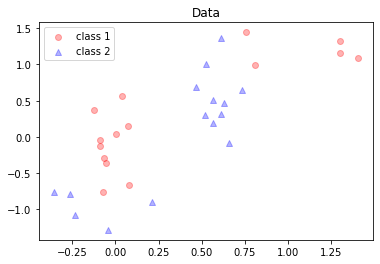

In [8]:
# generate mixture of Gaussians (class 1 & class 2)
dim = 2
datanum1_1 = 10
datanum1_2 = 5
datanum2_1 = 10
datanum2_2 = 5
datanum1 = datanum1_1 + datanum1_2
datanum2 = datanum2_1 + datanum2_2
mean1_1 = np.array([0, 0])
mean1_2 = np.array([1, 1])
mean2_1 = np.array([.5, .5])
mean2_2 = np.array([0, -1])
cov1_1 = np.array([[.01,0],[0,.2]])
cov1_2 = np.array([[.1,.02],[.02,.1]])
cov2_1 = np.array([[.02,0],[0,.2]])
cov2_2 = np.array([[.1,-.01],[-.01,.05]])
data1_1 = np.random.multivariate_normal(mean1_1, cov1_1, datanum1_1)
data1_2 = np.random.multivariate_normal(mean1_2, cov1_2, datanum1_2)
data2_1 = np.random.multivariate_normal(mean2_1, cov2_1, datanum2_1)
data2_2 = np.random.multivariate_normal(mean2_2, cov2_2, datanum2_2)
data1 = np.concatenate((data1_1, data1_2), axis=0)
data2 = np.concatenate((data2_1, data2_2), axis=0)

tstdatanum1_1 = 100
tstdatanum1_2 = 100
tstdatanum2_1 = 100
tstdatanum2_2 = 100
tstdatanum1 = tstdatanum1_1 + tstdatanum1_2
tstdatanum2 = tstdatanum2_1 + tstdatanum2_2
tstdata1_1 = np.random.multivariate_normal(mean1_1, cov1_1, tstdatanum1_1)
tstdata1_2 = np.random.multivariate_normal(mean1_2, cov1_2, tstdatanum1_2)
tstdata2_1 = np.random.multivariate_normal(mean2_1, cov2_1, tstdatanum2_1)
tstdata2_2 = np.random.multivariate_normal(mean2_2, cov2_2, tstdatanum2_2)
tstdata1 = np.concatenate((tstdata1_1, tstdata1_2), axis=0)
tstdata2 = np.concatenate((tstdata2_1, tstdata2_2), axis=0)

fig, ax = plt.subplots()
# draw_state_linear(ax)
plot_data(ax)

### Learning with logistic regression (without kernel)

In [9]:
# Initialize parameters
w_init = np.random.normal(0,1,dim)
b_init = np.random.normal(0,1,1)

# extended w: [w, -b]
extw = np.array([np.concatenate((w_init, -b_init))])
# data with '1' is appended: [X, 1]
extX = np.concatenate((np.concatenate((data1, data2), axis=0), \
                       np.ones([datanum1 + datanum2, 1])), axis=1)
labels = np.concatenate((np.ones(datanum1), np.zeros(datanum2)))  # label of class 1: 1, label of class 2: 0


In [10]:
def update_w(extw, extX, labels, num_update=100, step_size=0.001, reg_const=1):
    fig, ax = plt.subplots()
    draw_state_linear(ax, extw[0,0:2], -extw[0,2], 'Updated boundary')

    objective_history = []
    for i in range(num_update):
        ts = np.matmul(extX, extw.T)  # w^TX
        fs = logistic_function(ts)
        extw = extw + step_size*(np.matmul(np.array([labels]) - fs.T, extX) - reg_const*extw)
        objective_history.append(get_loss(labels, fs.T[0]))

    fig, ax = plt.subplots()
    draw_state_linear(ax, extw[0,0:2], -extw[0,2], 'Updated boundary')
    
    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")
    
    return extw


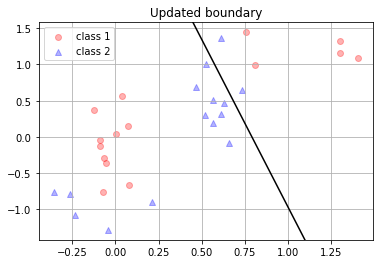

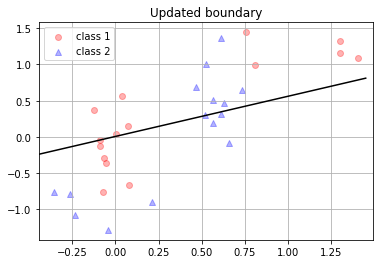

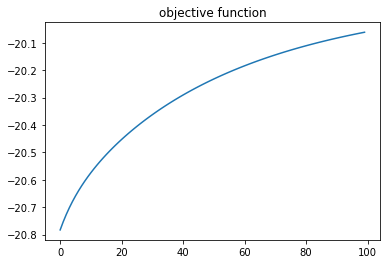

In [11]:
extw = update_w(extw, extX, labels, num_update=100, step_size=0.01, reg_const=1)

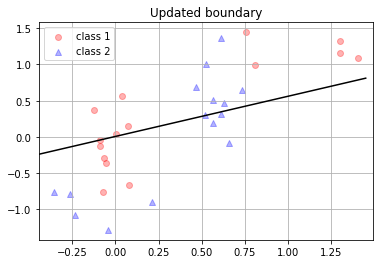

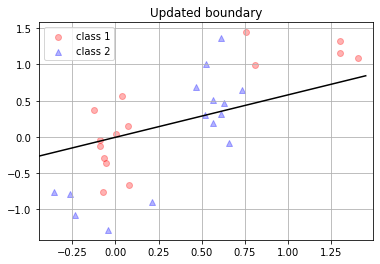

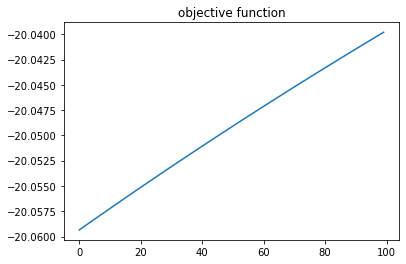

In [12]:
# Additional 100 updates
extw = update_w(extw, extX, labels, num_update=100, step_size=0.001)

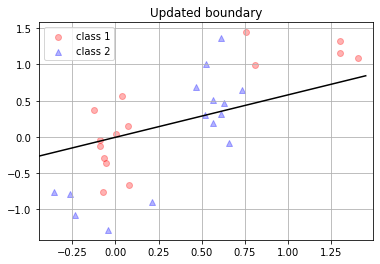

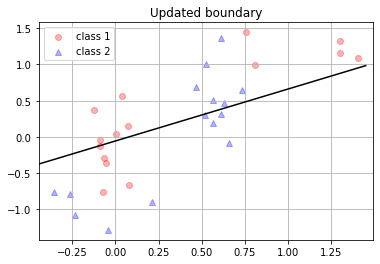

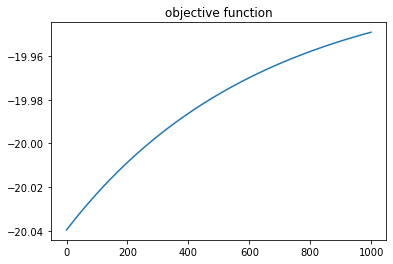

In [13]:
# After enough updates
extw = update_w(extw, extX, labels, num_update=1000, step_size=0.001)

#### Evaluation

In [14]:
# data with '1' is appended: [X, 1]
extTstX = np.concatenate((np.concatenate((tstdata1, tstdata2), axis=0), \
                       np.ones([tstdatanum1 + tstdatanum2, 1])), axis=1)
tstlabels = np.concatenate((np.ones(tstdatanum1), np.zeros(tstdatanum2)))

ts = np.matmul(extTstX, extw.T)  # w^TX
err_rate = np.sum(np.abs((ts.T > 0) - np.array([tstlabels])))/(tstdatanum1 + tstdatanum2)
print(err_rate)

0.3225


### Learning with logistic regression (with kernel)

\begin{eqnarray}
\frac{dL}{d\alpha_k} = \sum_{i = 1}^N (y_i - f(\mathbf{x}_i)) k(\mathbf{x}_k, \mathbf{x}_i)
\end{eqnarray}

In [15]:
def update_alpha(alphas, X, labels, num_update=100, step_size=0.001, reg_const=1):
    fig, ax = plt.subplots()
    draw_state_kernel(ax, alphas, 'Updated boundary')

    objective_history = []
    for i in range(num_update):
        Kmat = get_gaussian_kernel_matrix(X, X)
        ts = np.matmul(alphas, Kmat)  # K*alpha
        fs = logistic_function(ts)
        alphas = alphas + step_size*(np.matmul(labels - fs, Kmat) - reg_const*np.matmul(alphas, Kmat))
        objective_history.append(get_loss(labels, fs))


    fig, ax = plt.subplots()
    draw_state_kernel(ax, alphas, 'Updated boundary')
    
    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")
    
    return alphas


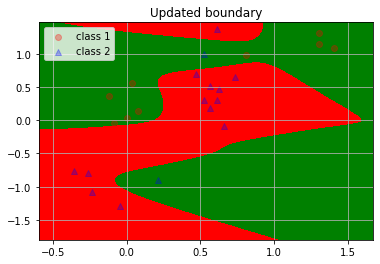

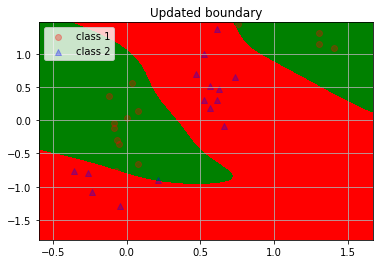

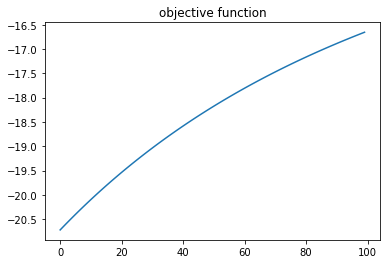

In [16]:
# alpha initialize
alphas = np.random.normal(0, 0.01, datanum1 + datanum2)
labels = np.concatenate((np.ones(datanum1), np.zeros(datanum2)))  # label of class 1: 1, label of class 2: 0
X = np.concatenate([data1, data2], axis=0)
alphas = update_alpha(alphas, X, labels, num_update=100, step_size=0.001, reg_const=1)


array([ 0.2623457 ,  0.25541875,  0.28837719,  0.26101371,  0.30373559,
        0.32510899,  0.16432706,  0.24036104,  0.27794976,  0.30741869,
        0.30316899,  0.33910422,  0.22205284,  0.14782782,  0.30058652,
       -0.1399731 , -0.19488754, -0.27316562, -0.27827668, -0.27976689,
       -0.24741534, -0.27893142, -0.21304021, -0.25328716, -0.27907214,
       -0.31317082, -0.32575585, -0.34545171, -0.18735541, -0.20245081])

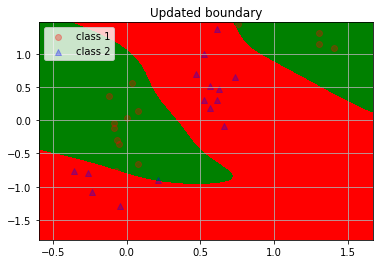

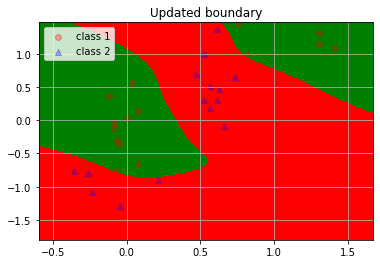

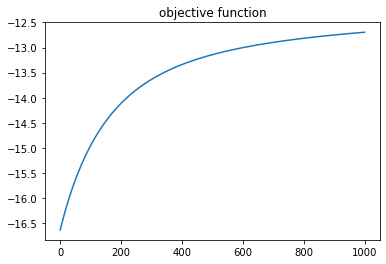

In [17]:
update_alpha(alphas, X, labels, num_update=1000, step_size=0.001, reg_const=1)

#### Evaluation

In [18]:
# data with '1' is appended: [X, 1]
tstX = (np.concatenate([tstdata1, tstdata2], axis=0))
tstlabels = np.concatenate([np.ones(tstdatanum1), np.zeros(tstdatanum2)], axis=0)

Kmat = get_gaussian_kernel_matrix(X, tstX)
ts = np.matmul(alphas, Kmat)  # K*alpha
err_rate = np.sum(np.abs((ts.T > 0) - np.array([tstlabels])))/(tstdatanum1 + tstdatanum2)
print(err_rate)

0.17
